In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [60]:
df = pd.read_csv("car_fuel_efficiency.csv")
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [61]:
cols_to_use = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
data = df[cols_to_use]
data.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

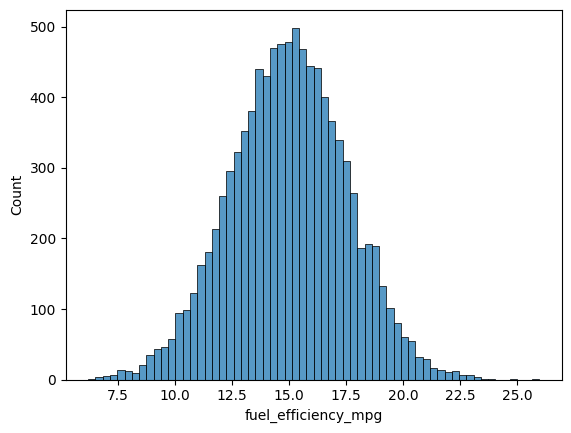

In [22]:
sns.histplot(data.fuel_efficiency_mpg)

In [62]:
data.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [63]:
data.horsepower.describe()

count    8996.000000
mean      149.657292
std        29.879555
min        37.000000
25%       130.000000
50%       149.000000
75%       170.000000
max       271.000000
Name: horsepower, dtype: float64

In [64]:
n = len(data)

idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)
idx

array([ 483, 7506, 8795, ..., 5390,  860, 7270], shape=(9704,))

In [65]:
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test

n, n_val + n_test + n_train

(9704, 9704)

In [66]:
df_train = data.iloc[idx[:n_train]]
df_val = data.iloc[idx[n_train:n_train + n_val]]
df_test = data.iloc[idx[n_train + n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [67]:
df_train.shape, df_val.shape, df_test.shape, y_train.shape, y_val.shape, y_test.shape

((5824, 4), (1940, 4), (1940, 4), (5824,), (1940,), (1940,))

In [68]:
def prepare_X(df, fill_method="zeroes"):

    df = df.copy()     

    if fill_method == "zeroes":
        df = df.fillna(0)
    elif fill_method == "mean":
        mean_value = df_train.horsepower.mean()  # Using only the train to fill the na with the mean
        df = df.fillna(mean_value)


    X = df.values
    return X

In [74]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)
    

In [75]:
# Model with zero fill

X_train = prepare_X(df_train, fill_method="zeroes")
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fill_method="zeroes")
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.5173782638841185)

In [76]:
# Model with mean fill

X_train = prepare_X(df_train, fill_method="mean")
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fill_method="mean")
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred)

np.float64(0.4635965042344029)

In [72]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [80]:
# Let's round to more decimal places to see differences
X_train = prepare_X(df_train, fill_method="zeroes")

rmse_values = []
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(X_train, y_train, r)

    X_val = prepare_X(df_val, fill_method="zeroes")
    y_pred = w0 + X_val.dot(w)

    score_exact = rmse(y_val, y_pred)
    rmse_values.append((r, score_exact))
    
    print(f"r: {r:>5}, RMSE: {score_exact:.6f}, rounded to 2: {round(score_exact, 2)}")

# Find the best r value
best_r, best_rmse = min(rmse_values, key=lambda x: x[1])
print(f"\nBest r value: {best_r} with RMSE: {best_rmse:.10f}")

r:     0, RMSE: 0.517378, rounded to 2: 0.52
r:  0.01, RMSE: 0.517112, rounded to 2: 0.52
r:   0.1, RMSE: 0.518753, rounded to 2: 0.52
r:     1, RMSE: 0.522235, rounded to 2: 0.52
r:     5, RMSE: 0.522892, rounded to 2: 0.52
r:    10, RMSE: 0.522981, rounded to 2: 0.52
r:   100, RMSE: 0.523064, rounded to 2: 0.52

Best r value: 0.01 with RMSE: 0.5171115526


In [93]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

for seed_value in seed_values:
    n = len(data)

    idx = np.arange(n)

    np.random.seed(seed_value)
    np.random.shuffle(idx)

    df_train = data.iloc[idx[:n_train]]
    df_val = data.iloc[idx[n_train:n_train + n_val]]
    df_test = data.iloc[idx[n_train + n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    # Model with zero fill

    X_train = prepare_X(df_train, fill_method="zeroes")
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, fill_method="zeroes")
    y_pred = w0 + X_val.dot(w)

    rmse_scores.append(rmse(y_val, y_pred))

print(f"Standard deviation of all rmse scores: {round(np.std(rmse_scores), 3)}")

Standard deviation of all rmse scores: 0.007


In [94]:
n = len(data)

idx = np.arange(n)

np.random.seed(9)
np.random.shuffle(idx)

df_train = data.iloc[idx[:n_train]]
df_val = data.iloc[idx[n_train:n_train + n_val]]
df_test = data.iloc[idx[n_train + n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_full_train = pd.concat([df_train, df_val])
df_full_train= df_full_train.reset_index(drop=True)

# Model with zero fill

X_full_train = prepare_X(df_full_train, fill_method="zeroes")
y_full_train =  np.concatenate([y_train, y_val])

w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

X_test = prepare_X(df_test, fill_method="zeroes")
y_pred = w0 + X_test.dot(w)

rmse(y_test, y_pred)



np.float64(0.5156261299185628)